In [1]:
import argparse
import datetime
import json
import random
import logging
import os
import io
import sys
import duckdb
import numpy as np

from tqdm import tqdm
from pprint import pprint

from IPython.display import Image, display


from utils.utils import dynamic_import, load_config

from typing import Annotated, Union,Optional
from typing_extensions import TypedDict, Literal

from pydantic import BaseModel, field_validator, ValidationError, Field, model_validator

# from IPython.display import Image, display

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage, ToolMessage, AnyMessage
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.tools import BaseTool, tool
from langchain_core.runnables import RunnableConfig
from langchain_ollama import OllamaLLM, ChatOllama

from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [2]:
def setup_logger() -> logging.Logger:
    """Setup the logger configuration for consistency."""
    logging.basicConfig(
        level=logging.INFO,
        format="%(asctime)s [%(levelname)s] %(name)s: %(message)s",
        handlers=[logging.StreamHandler()],
    )
    return logging.getLogger(__name__)


logger = setup_logger()

## Get the data from the db

In [3]:
def get_text_from_db(conn, table_sections, pmcid):
    """
    Get the already recorded pmcids from db
    """
    cursor = conn.cursor()
    query = f"""
        SELECT abstract, INTRO, METHODS, SUBJECTS, RESULTS, DISCUSSION, CONCLUSION
        FROM {table_sections} 
        WHERE pmcid = ?
    """
    cursor.execute(query, (pmcid,))
    row = cursor.fetchone()
    cursor.close()
    if row:
        abstract, intro, method, subjects, results, discussion, conclusion = row
        return abstract, intro, method, subjects, results, discussion, conclusion
    else:
        return None, None, None, None, None, None, None

In [5]:
# Load config
config_path = os.path.join("../config", "config.yaml")
config_all = load_config(config_path)

# DB connection
# # Name of the database
DB_FILE = config_all["api_europepmc_params"]["db_info_articles"]
table_status = config_all["db_params"]["table_status"]
table_sections = config_all["db_params"]["table_sections"]
table_metadata = config_all["db_params"]["table_metadata"]
table_inference = config_all["db_params"]["table_inference"]
# # Using duckdb to access the sqlite file for compatibility on marenostrum
conn = duckdb.connect(f"../{DB_FILE}")

# List of PMCID for testing

list_pmcids = [
 "PMC10167034", "PMC10191296",   "PMC10390885", "PMC1368980", "PMC2383879", "PMC2693442", "PMC3041764", "PMC3145824", "PMC3174812", "PMC3212907", 
 "PMC3219398",  "PMC3534646", "PMC3804564", "PMC3909226", "PMC4029655", "PMC4393161", "PMC4640153", "PMC4928460", "PMC5040013", "PMC5308745", 
 "PMC5425199", "PMC5441889", "PMC5601641", "PMC5717332", "PMC5839230", "PMC5961641", "PMC6060212",   "PMC6076250", "PMC6286024","PMC6730009", 
 "PMC6760014", "PMC6775309", "PMC6853912", "PMC6858051", "PMC6955584", "PMC7007877", "PMC7449478", "PMC7657407", "PMC7661891", "PMC8155599", 
 "PMC8288503", "PMC8382172", "PMC8771850", "PMC8976245", "PMC9333080", "PMC9381901",   "PMC9529122", "PMC9616492", "PMC9697589"
]

pmcid_method = list()
for pmcid in list_pmcids[0:2]:
    
    abstract, intro, method, subjects, results, discussion, conclusion  = get_text_from_db(conn, table_sections, pmcid)
    pmcid_method.append({'pmcid': pmcid, 
                         'abstract': abstract, 
                         'intro': intro, 
                         'method': method, 
                         'subjects': subjects,
                         'results': results,
                         'discussion': discussion,
                         'conclusion': conclusion})

In [18]:
# Pydantic parsers
from pydantic import BaseModel, Field, model_validator
import json
import ast

class BooleanParser(BaseModel):
    answer: bool = Field(description="Must be either 'True' or 'False'")
    
    @model_validator(mode="before")
    @classmethod
    def preprocess_input(cls, values: dict) -> dict:
        raw_answer = values.get("answer")
        
        if isinstance(raw_answer, str):
            # Clean and convert string if necessary
            raw_answer = cls._clean_and_convert_string(raw_answer)
        
        # Handle case where raw_answer is a dictionary with an 'answer' field
        if isinstance(raw_answer, dict) and "answer" in raw_answer:
            raw_answer = raw_answer["answer"]
        
        # If it's still a string, check for valid "true"/"false" values
        if isinstance(raw_answer, str):
            stripped_answer = raw_answer.strip().lower()
            if stripped_answer in ("true", "false"):
                raw_answer = stripped_answer == "true"
        
        # If the answer is neither boolean nor string, raise an error
        if not isinstance(raw_answer, bool):
            raise ValueError(f"Answer must be 'True' or 'False', got: {raw_answer}")
        
        values["answer"] = raw_answer
        return values

    @staticmethod
    def _clean_and_convert_string(raw_answer: str) -> any:
        raw_answer = raw_answer.strip("`").strip()
        
        if raw_answer.startswith('```json') and raw_answer.endswith('```'):
            # Remove the ```json``` markers
            raw_answer = raw_answer[7:-3].strip()

        # Replace 'True'/'False' to lowercase for uniformity
        raw_answer = raw_answer.replace("True", "true").replace("False", "false")
        
        try:
            # Try to parse as JSON
            raw_answer = json.loads(raw_answer)
        except json.JSONDecodeError:
            try:
                # Try to evaluate as a Python literal
                raw_answer = ast.literal_eval(raw_answer)
            except (ValueError, SyntaxError):
                print(f"Failed to parse raw_answer: {raw_answer}")
                pass
        
        return raw_answer
    
    @model_validator(mode="after")
    @classmethod
    def validate_answer(cls, model: "BooleanParser") -> "BooleanParser":
        if not isinstance(model.answer, bool):
            raise ValueError(f"Answer must be a boolean (True or False), got: {model.answer}")
        return model
    
    
class ContextParser(BooleanParser):
    context: str = Field(default='', description="Relevant sentences or data supporting the decision")

    @model_validator(mode="before")
    @classmethod
    def preprocess_input(cls, values: dict) -> dict:
        # First, handle BooleanParser preprocessing
        values = super().preprocess_input(values)

        # Additional preprocessing for context
        raw_context = values.get("context", "")
        if isinstance(raw_context, str):
            values["context"] = raw_context.strip()

        return values

In [19]:
# Tools
@tool
def extract_section_tool(article: dict, section: str) -> str:
    """
    Extracts a specific section (e.g., 'Abstract', 'Method', 'Result') from a single document dictionary.
    If the section does not exist, returns an empty string.
    """
    return article.get(section, "No content available.")

In [39]:
## Instanciate LLMs
#model_name = "qwen2.5:3b"
model_name = "llama3.2:3b-instruct-fp16"

llm = ChatOllama(model=model_name)
llm.temperature = 0

In [40]:
class DecisionState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages] = [] # Message when using tools calls and talk between agents. 
    article: dict = Field(default = "", description="dictionary containing severa sections of the article")
    human_subjects: str = Field(default="", description="Does the article contain information about human subjects")
    sex_or_sample_data: bool = Field(default=False, description="Does the article contains information about the sex of the subjects")
    multi_sample: str = Field(default="", description="Does the research involves several samples")
    #one_subject: str = Field(default="", description="Does the samples provides from the same subject")
    multi_cohorts: str = Field(default="", description="Are there several cohorts")
    cohorts_overlap: str = Field(default="", description="Are some subjects present in more than one cohort")
    dropouts_before: str = Field(default="", description="Are there participants who drop the studies before the research started")
    dropouts_during: str = Field(default="", description="Are there participants who drop the studies during the research")
    droupouts_after: str = Field(default="", description="Are there participants who drop the studies after the research")
    info_text: bool = Field(default=False, description="Is the information contained in the text")
    info_table: bool = Field(default=False, description="Is the information contained in table")

class ResultResponse(TypedDict):
    n_male: float = Field(default=np.nan, description="The total number of unique male reported in the paper")
    n_female: float = Field(default=np.nan, description="The total number of unique female reported in the paper")
    n_sample: float = Field(default=np.nan, description="The total number of unique participants reported in the paper")

class FinalResponse(DecisionState, ResultResponse):
    pass

In [41]:
@tool
def get_human_presence(article: str):
    """
    Determines if the article passed as argument discusses human subjects by querying different sections of a single document.
    The function return True if it talks about humans and false if not
    """
    
    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    You can call tools to extract specific sections of the document.
    """
    user_message = """
    Your task is to determine if the article consider human subjects for a study. 
    Analyze the following document
    {article}
    Answer as follows:
    - 'True': The document mentions human subjects.
    - 'False': The document does not mention human subjects, or there is not enough information to take an informed decision

    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    Fully respect the format_instruction and don't answer anything more than what it is asked
    """
  
    parser = PydanticOutputParser(pydantic_object=BooleanParser)

    PromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=article, format_instructions=parser.get_format_instructions())
    response = llm.invoke(prompt_messages)

    try:
        # print(f"The full answer: {response}")
        print(f"The response content: {response.content}")
        parsed_response = parser.invoke(response.content)
            #print(f"Parsed response: {parsed_response.answer}")

        if parsed_response.answer == True:  # If 'True' is found, return immediately
            return True
    except ValueError as e:
        print(f"Error in human node: {response}")
        raise ValueError("Validation failed for model: " + str(e))

    return False



In [42]:
@tool
def get_sex_information(article: str):
    """Call to know if the article contains information about the sex or the gender of human subjects contained in the study. Will return True or False"""
    
    system_message = """
    You are a helpful assistant analyzing a scientific article. 
    """
    user_message = """
    The article includes experiment involving human subjects. 
    Your task is to determine the presence of information about sex or gender in the section. 
    
    Here, 4 non-exhaustive examples of what it may look like:
    #######

    Example 1: Twenty-seven subjects (age range 19–58, ten female) diagnosed with an ASD (see Table 1) participated in this study. 
    ASD diagnosis was determined using the Autism Diagnostic Observation Schedule (ADOS), 
    Module 4. Additionally, fifteen typical adults recruited from the local community served as behavioral controls (age range 19–59) and only participated in the face discrimination experiment described in Section 2.3.

    Example 2: The strategy was to select contrasting groups including the 200 women and men (100 each) with the highest EE scores, 200 with medium EE and 200 with the lowest EE scores. 
    After plotting the EE scores for women and men separately, the cutoff was set around the highest quartile, the median and around the lowest quartile. 
    The selection procedures yielded a sample of 720 individuals. Some of them enrolled in a parallel study were excluded. 
    As a result, the final sample included 687 individuals consisting of 143 women and 127 men with low EE scores, 118 women and 110 men with medium EE scores and 119 women and 103 men with high EE scores.

    Example 3: Table 1Subject characteristics at baseline1VLCARBVLFHUFmales/females4/205/173/18BMI kg/m232.5 \u00b1 3.132.6 \u00b1 4.033.4 \u00b1 3.6AGE y48.4 \u00b1 8.050.7 \u00b1 10.346.1 \u00b1 9.5Total Cholesterol mmol/L5.8 \u00b1 1.05.6 \u00b1 1.16.0 \u00b1 1.1LDL-C mmol/L3.8 \u00b1 0.83.6 \u00b1 1.14.0 \u00b1 1.1HDL-C mmol/L1.2 \u00b1 0.21.3 \u00b1 0.31.2 \u00b1 0.2Triacylglycerols mmol/L1.8 \u00b1 0.91.5 \u00b1 0.61.6 \u00b1 0.51 Data are Mean \u00b1 SD. VLCARB = very low carbohydrate diet (n = 24) VLF = very low fat diet (n = 22) HUF = high unsaturated fat (n = 21)

    Example 4:Fifteen healthy human volunteers took part in the study. They were screened for normal stereoacuity before being invited to participate. 
    Two were later excluded because of poor binocular fusion during scanning. Therefore, data from 13 participants (10 female; mean age 27 yr) were included in the analysis.
    ########
    
    Analyze the following document
    {article}
    Answer as follows:
    - 'True': The document contains information to know if some participants are males or females or if the information about the gender is given. Even if only one gender or sex can be inferred, answer True
    - 'False': The document does not contain information about the sex or the gender of the participants.
    Additionally, if the answer is 'True', include the relevant sentences or table excerpts from the section that support your decision in the 'context' field
    If the document is empty, just answer False, I will provide another section to try again.
    
    Important: You need to answer the question following this format instructions:\n\n{format_instructions}
    Fully respect the format_instruction and don't answer anything more than what it is asked
    """
  
    parser = PydanticOutputParser(pydantic_object=BooleanParser)

    PromptTemplate.from_messages([("system", system_message), ("user", user_message)])

    prompt_messages = chat_prompt.format_messages(article=article, format_instructions=parser.get_format_instructions())
    response = llm.invoke(prompt_messages)

    try:
        # print(f"The full answer: {response}")
        print(f"The response content: {response.content}")
        parsed_response = parser.invoke(response.content)
            #print(f"Parsed response: {parsed_response.answer}")

        if parsed_response.answer == True:  # If 'True' is found, return immediately
            return True
    except ValueError as e:
        print(f"Error in human node: {response}")
        raise ValueError("Validation failed for model: " + str(e))

    return False


In [43]:

tools = [get_human_presence, get_sex_information]
llm = llm.bind_tools(tools)


In [44]:

tools_by_name = {tool.name: tool for tool in tools}

# Define our tool node
def tool_node(state: DecisionState):
    outputs = []
    for tool_call in state["messages"][-1].tool_calls:
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}


def call_model(state: DecisionState, config:RunnableConfig): 
    # this is similar to customizing the create_react_agent with state_modifier, but is a lot more flexible
    system_prompt = SystemMessage(
        "You are a helpful AI assistant, please respond to the users query to the best of your ability!"
    )
    response = llm.invoke([system_prompt] + state["messages"], config)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: DecisionState):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        # if human and sample:
        #    return extract_number
        #else:
        #    return "end"
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

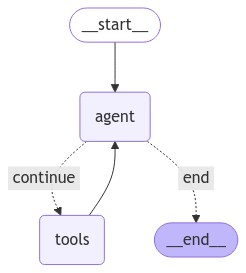

In [45]:
# Define a new graph
workflow = StateGraph(DecisionState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "tools",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("tools", "agent")

# Now we can compile and visualize our graph
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
# Helper function for formatting the stream nicely
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()





for article in pmcid_method[0:]:
    inputs = {"messages": [("user", f"I wil give you a scientific article. Read it and then answer the question I ask you at the end of this prompt: {article}\n\n 1. Does the article contains human subjects. Does the article contains information about sex or gender")]}
    print_stream(graph.stream(inputs, stream_mode="values"))


================================ Human Message =================================

I wil give you a scientific article. Read it and then answer the question I ask you at the end of this prompt: {'pmcid': 'PMC10167034', 'abstract': None, 'intro': '1 Introduction Sepsis remains a leading cause of death in intensive care units (ICU), with a mortality rate of approximately 15-25% ( 1 – 3 ). Vascular dysfunction, a feared complication of sepsis, can result in acute respiratory distress syndrome (ARDS), acute renal failure (ARF), and even mortality ( 4 , 5 ). However, existing prognostic tools are hindered by complexity and biases leading to imperfect predictive capabilities ( 6 – 9 ). Further, the heterogeneity of sepsis at the individual patient level has also hindered therapeutic advances in the field ( 10 ). Decades of investigative efforts in the absence of sepsis endotyping have yielded no conclusively effective therapies to date. Understanding the heterogeneity of sepsis and subgroupin